## Importing the req. Modules

In [118]:
import os
import matplotlib.pyplot as plt
import mplcyberpunk
import numpy as np
import cv2
import random
import tensorflow as tf

In [119]:
from keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow import keras
import keras.backend as K
from keras.optimizers import Adam , SGD
from tensorflow.keras.losses import binary_crossentropy
from keras.layers import Convolution2D,BatchNormalization,ReLU,LeakyReLU,Add
from keras.layers import GlobalAveragePooling2D,AveragePooling2D,UpSampling2D
from keras.layers import Input, Lambda, Layer , Reshape
from keras.layers.core import Activation, Reshape, Dense
from sklearn.model_selection import train_test_split

## Data Preparation

In [120]:
SEED = 42

random.seed(42)

np.random.seed = SEED

plt.style.use("cyberpunk")

In [121]:
IMAGE_PATH = 'aug_data/aug_images/'
MASK_PATH = 'aug_data/aug_masks/'

IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3

In [122]:
image_files = next(os.walk(IMAGE_PATH))[2]
mask_files = next(os.walk(MASK_PATH))[2]

In [123]:
image_files = sorted(image_files)
mask_files = sorted(mask_files)

In [124]:
print("IMAGE files names\n",  image_files,  "\n\n" , "MASKS files names\n", mask_files)

IMAGE files names
 ['TCGA-18-5592-01Z-00-DX1_0.png', 'TCGA-18-5592-01Z-00-DX1_1.png', 'TCGA-18-5592-01Z-00-DX1_10.png', 'TCGA-18-5592-01Z-00-DX1_11.png', 'TCGA-18-5592-01Z-00-DX1_12.png', 'TCGA-18-5592-01Z-00-DX1_13.png', 'TCGA-18-5592-01Z-00-DX1_14.png', 'TCGA-18-5592-01Z-00-DX1_15.png', 'TCGA-18-5592-01Z-00-DX1_16.png', 'TCGA-18-5592-01Z-00-DX1_17.png', 'TCGA-18-5592-01Z-00-DX1_18.png', 'TCGA-18-5592-01Z-00-DX1_19.png', 'TCGA-18-5592-01Z-00-DX1_2.png', 'TCGA-18-5592-01Z-00-DX1_3.png', 'TCGA-18-5592-01Z-00-DX1_4.png', 'TCGA-18-5592-01Z-00-DX1_5.png', 'TCGA-18-5592-01Z-00-DX1_6.png', 'TCGA-18-5592-01Z-00-DX1_7.png', 'TCGA-18-5592-01Z-00-DX1_8.png', 'TCGA-18-5592-01Z-00-DX1_9.png', 'TCGA-21-5784-01Z-00-DX1_0.png', 'TCGA-21-5784-01Z-00-DX1_1.png', 'TCGA-21-5784-01Z-00-DX1_10.png', 'TCGA-21-5784-01Z-00-DX1_11.png', 'TCGA-21-5784-01Z-00-DX1_12.png', 'TCGA-21-5784-01Z-00-DX1_13.png', 'TCGA-21-5784-01Z-00-DX1_14.png', 'TCGA-21-5784-01Z-00-DX1_15.png', 'TCGA-21-5784-01Z-00-DX1_16.png', 'TCGA-

In [125]:
len(image_files) , len(mask_files)

(600, 600)

##### Plotting random image

In [126]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 2, figsize=(8, 8))
        
        ax[0].imshow(image)
        ax[0].grid(False)
        ax[1].imshow(mask)
        ax[1].grid(False)
        
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].grid(False)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].grid(False)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].grid(False)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].grid(False)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)


In [127]:
test_image = cv2.imread('aug_data/aug_images/TCGA-18-5592-01Z-00-DX1_2.png')
test_mask = cv2.imread('aug_data/aug_masks/TCGA-18-5592-01Z-00-DX1_2.png')

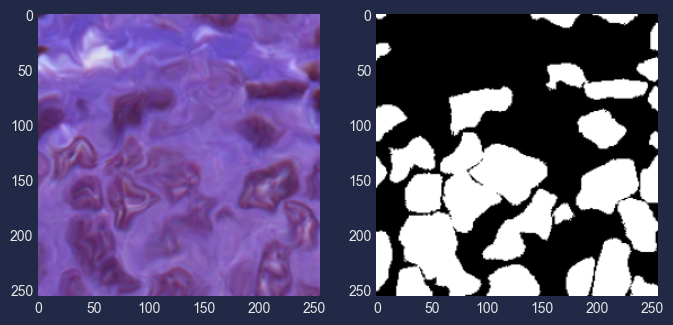

In [128]:
visualize(test_image,test_mask)

In [129]:
X = np.zeros((len(image_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(mask_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype = bool)

In [130]:
X.shape , Y.shape

((600, 256, 256, 3), (600, 256, 256, 1))

In [131]:
# temp_mask = cv2.imread('masks/TCGA-18-5592-01Z-00-DX1.png',cv2.IMREAD_GRAYSCALE)
# temp_mask.shape

#### Defining the variables and splitting them into Train, Test and Val

In [132]:
for i in range(len(image_files)):

    image = cv2.imread(os.path.join(IMAGE_PATH + image_files[i]))
    mask = cv2.imread(os.path.join(MASK_PATH + image_files[i]),cv2.IMREAD_GRAYSCALE)

    mask = np.expand_dims(mask , axis=-1)
    
    X[i] = image
    Y[i] = mask

In [133]:
X.shape , Y.shape

((600, 256, 256, 3), (600, 256, 256, 1))

In [134]:
X_train,X_testval,Y_train,Y_testval = train_test_split(X,Y, test_size=0.25, random_state=SEED)

In [135]:
X_train.shape , X_testval.shape

((450, 256, 256, 3), (150, 256, 256, 3))

In [136]:
X_test,X_val,Y_test,Y_val = train_test_split(X_testval,Y_testval,test_size=0.5,random_state=SEED)

In [137]:
X_test.shape , X_val.shape 

((75, 256, 256, 3), (75, 256, 256, 3))

## Metrics

In [31]:
# to evaluate the overlap between predicted and ground truth segmentation masks.
def dice_coef(y_true, y_pred, smooth=1):   
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou



#to optimize segmentation models for better delineation of objects in medical imagery.
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

In [138]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=7, monitor='val_loss'),
        tf.keras.callbacks.ReduceLROnPlateau(monitor = 'loss',factor = 0.1, patience = 3, verbose = 3, min_delta = 0.0001)]

## Unet

In [139]:
# Normalizing the images before sending them to the model.
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)  

# Encoding Block
# 1st Conv2D Block
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
# 2nd Conv2D Block
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
# 3rd Conv2D Block
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
# 4th Conv2D Block
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
# Middle
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Decoding Block
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model_unet = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model_unet.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy']) #,dice_coef,dice_loss,iou_coef,bce_dice_loss])
model_unet.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_8 (Lambda)              (None, 256, 256, 3)  0           ['input_18[0][0]']               
                                                                                                  
 conv2d_93 (Conv2D)             (None, 256, 256, 16  448         ['lambda_8[0][0]']               
                                )                                                                 
                                                                                            

In [140]:
history = model_unet.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=200,callbacks=callbacks)

Epoch 1/200
15/15 [==============================] - 17s 378ms/step - loss: 0.6478 - accuracy: 0.6012 - val_loss: 0.5857 - val_accuracy: 0.6546 - lr: 0.0010
Epoch 2/200
15/15 [==============================] - 4s 247ms/step - loss: 0.5653 - accuracy: 0.6718 - val_loss: 0.5482 - val_accuracy: 0.6552 - lr: 0.0010
Epoch 3/200
15/15 [==============================] - 4s 242ms/step - loss: 0.5267 - accuracy: 0.6883 - val_loss: 0.5038 - val_accuracy: 0.7263 - lr: 0.0010
Epoch 4/200
15/15 [==============================] - 4s 246ms/step - loss: 0.4976 - accuracy: 0.7693 - val_loss: 0.4575 - val_accuracy: 0.7962 - lr: 0.0010
Epoch 5/200
15/15 [==============================] - 4s 243ms/step - loss: 0.4690 - accuracy: 0.7864 - val_loss: 0.4605 - val_accuracy: 0.7861 - lr: 0.0010
Epoch 6/200
15/15 [==============================] - 4s 241ms/step - loss: 0.4531 - accuracy: 0.7917 - val_loss: 0.4148 - val_accuracy: 0.8156 - lr: 0.0010
Epoch 7/200
15/15 [==============================] - 4s 239ms/s

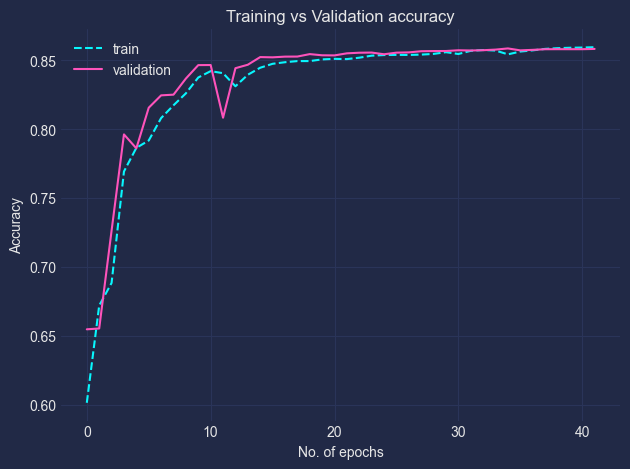

In [141]:
plt.plot(history.history['accuracy'],'--')
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'validation'], loc='upper left')
plt.title("Training vs Validation accuracy")
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.savefig('Unet_accuracy.png')

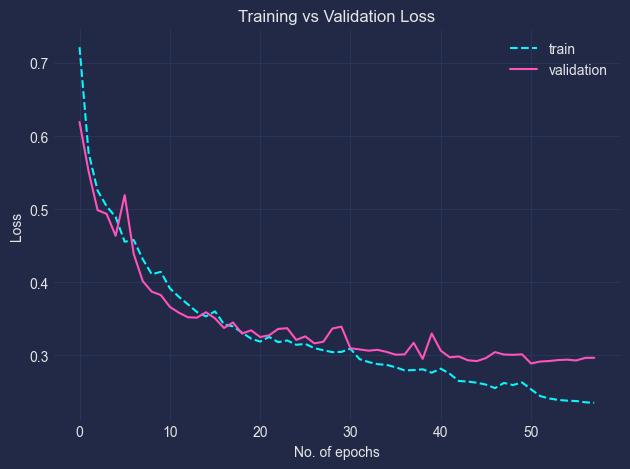

In [47]:
plt.plot(history.history['loss'],'--')
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper right')
plt.title("Training vs Validation Loss")
plt.xlabel("No. of epochs")
plt.ylabel("Loss")
plt.tight_layout()
plt.savefig('Unet_loss.png')

In [142]:
model_unet.save('unet.h5')

## SEGNET

In [33]:
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

In [34]:
input_shape

(256, 256, 3)

In [35]:
class MaxPoolingWithArgmax2D(Layer):

    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        # print("max pooling with argmax")
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == 'tensorflow':
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = tf.nn.max_pool_with_argmax(
                    inputs,
                    ksize=ksize,
                    strides=strides,
                    padding=padding)
        else:
            errmsg = '{} backend is not supported for layer {}'.format(
                    K.backend(), type(self).__name__)
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        # print("i guess its subsampling")
        ratio = (1, 2, 2, 1)
        output_shape = [
                dim//ratio[idx]
                if dim is not None else None
                for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]


    def compute_mask(self, inputs, mask=None):
        # print("no idea what this is: but computing mask")
        return 2 * [None]

class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        # one is pool and one is mask
        updates, mask = inputs[0], inputs[1]

        with tf.compat.v1.variable_scope(self.name):
            mask = K.cast(mask, 'int32')
            input_shape = tf.shape(updates, out_type='int32')     # it gives a dynamic shape of a given tensor. 

            #  calculation new shape
            if output_shape is None:
                output_shape = (
                        input_shape[0],
                        input_shape[1]*self.size[0],
                        input_shape[2]*self.size[1],
                        input_shape[3])
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype='int32')      #creates ones of the same shape as the mask
            batch_shape = K.concatenate([[input_shape[0]], [1], [1], [1]], axis=0)
            batch_range = K.reshape(tf.range(output_shape[0], dtype='int32'),shape=batch_shape)
            b = one_like_mask * batch_range

            y = mask // (output_shape[2] * output_shape[3])

            x = (mask // output_shape[3]) % output_shape[2]

            feature_range = tf.range(output_shape[3], dtype='int32')

            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = tf.size(updates)       # Prints the number of elements in the updates
            indices = K.transpose(K.reshape(K.stack([b, y, x, f]), [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
                mask_shape[0],
                mask_shape[1]*self.size[0],
                mask_shape[2]*self.size[1],
                mask_shape[3]
                )

In [62]:
def segnet(
        input_shape,
        kernel=3,
        pool_size=(2, 2),):


    inputs = Input(shape = input_shape)
    s = Lambda(lambda x : x / 255)(inputs)
    
    conv_1 = Convolution2D(64, (3, 3), padding="same", kernel_initializer='he_normal', name="block1_conv1")(s)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(64, (3, 3), padding="same", kernel_initializer='he_normal', name="block1_conv2")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)
    
    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size, name="block1_pool")(conv_2)
    
    conv_3 = Convolution2D(128, (3, 3), padding="same" , kernel_initializer='he_normal', name="block2_conv1")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128, (3, 3), padding="same", kernel_initializer='he_normal',  name="block2_conv2")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)
    
    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size, name="block2_pool")(conv_4)
    
    conv_5 = Convolution2D(256, (3, 3), padding="same" , kernel_initializer='he_normal', name="block3_conv1")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256, (3, 3), padding="same" , kernel_initializer='he_normal', name="block3_conv2")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Convolution2D(256, (3, 3), padding="same" , kernel_initializer='he_normal', name="block3_conv3")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)
    
    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size, name="block3_pool")(conv_7)
    
    conv_8 = Convolution2D(512, (3, 3), padding="same", kernel_initializer='he_normal', name="block4_conv1")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Convolution2D(512, (3, 3), padding="same" , kernel_initializer='he_normal', name="block4_conv2")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Convolution2D(512, (3, 3), padding="same" , kernel_initializer='he_normal', name="block4_conv3")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)
    
    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size, name="block4_pool")(conv_10)
    
    conv_11 = Convolution2D(512, (3, 3), padding="same", kernel_initializer='he_normal', name="block5_conv1")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Convolution2D(512, (3, 3), padding="same" , kernel_initializer='he_normal',  name="block5_conv2")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Convolution2D(512, (3, 3), padding="same" , kernel_initializer='he_normal',  name="block5_conv3")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)
    
    pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size, name="block5_pool")(conv_13)
    
    # decoder
    unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])
    
    conv_14 = Convolution2D(512, (3, 3), padding="same", kernel_initializer='he_normal')(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Convolution2D(512, (3, 3), padding="same", kernel_initializer='he_normal')(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Convolution2D(512, (3, 3), padding="same", kernel_initializer='he_normal')(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)
    
    unpool_2 = MaxUnpooling2D(pool_size)([conv_16, mask_4])
    
    conv_17 = Convolution2D(512, (3, 3), padding="same", kernel_initializer='he_normal')(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Convolution2D(512, (3, 3), padding="same", kernel_initializer='he_normal')(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Convolution2D(256, (3, 3), padding="same", kernel_initializer='he_normal')(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)
    
    unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])
    
    conv_20 = Convolution2D(256, (3, 3), padding="same", kernel_initializer='he_normal')(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(256, (3, 3), padding="same", kernel_initializer='he_normal')(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Convolution2D(128, (3, 3), padding="same", kernel_initializer='he_normal')(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)
    
    unpool_4 = MaxUnpooling2D(pool_size)([conv_22, mask_2])
    
    conv_23 = Convolution2D(128, (3, 3), padding="same", kernel_initializer='he_normal')(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(64, (3, 3), padding="same", kernel_initializer='he_normal')(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)
    
    unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])
    
    conv_25 = Convolution2D(64, (3, 3), padding="same", kernel_initializer='he_normal')(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    outputs = Convolution2D(1, (1, 1), activation='sigmoid')(conv_25)
    
    # conv_26 = Convolution2D(1, (1, 1), padding="same", kernel_initializer='he_normal')(conv_25)
    # conv_26 = BatchNormalization()(conv_26)

    # outputs = Reshape((256,256))(conv_26)
    # # outputs = Activation("sigmoid")(conv_26)
    
    model = Model(inputs=s, outputs=outputs, name="SegNet")
    model.compile(optimizer= Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy',dice_coef,dice_loss,iou_coef,bce_dice_loss])
    return model

In [63]:
model_seg = segnet(input_shape=input_shape) 

In [64]:
model_seg.summary()

Model: "SegNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_152 (Batch  (None, 256, 256, 64  256        ['block1_conv1[1][0]']           
 Normalization)                 )                                                            

In [65]:
history_seg = model_seg.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=100,batch_size=16,callbacks=callbacks)

Epoch 1/100
29/29 [==============================] - 29s 899ms/step - loss: 0.6707 - accuracy: 0.6300 - dice_coef: 0.3876 - dice_loss: 0.6124 - iou_coef: 0.2338 - bce_dice_loss: 0.9756 - val_loss: 38675.3633 - val_accuracy: 0.6549 - val_dice_coef: 0.0058 - val_dice_loss: 0.9942 - val_iou_coef: 0.0030 - val_bce_dice_loss: 38675.8633 - lr: 0.0010
Epoch 2/100
29/29 [==============================] - 25s 881ms/step - loss: 0.5323 - accuracy: 0.7565 - dice_coef: 0.4699 - dice_loss: 0.5301 - iou_coef: 0.2935 - bce_dice_loss: 0.7992 - val_loss: 13.8469 - val_accuracy: 0.6937 - val_dice_coef: 0.3818 - val_dice_loss: 0.6182 - val_iou_coef: 0.2303 - val_bce_dice_loss: 14.1566 - lr: 0.0010
Epoch 3/100
29/29 [==============================] - 26s 886ms/step - loss: 0.4826 - accuracy: 0.7840 - dice_coef: 0.5345 - dice_loss: 0.4655 - iou_coef: 0.3481 - bce_dice_loss: 0.7164 - val_loss: 4.7128 - val_accuracy: 0.5058 - val_dice_coef: 0.5504 - val_dice_loss: 0.4496 - val_iou_coef: 0.3776 - val_bce_dice

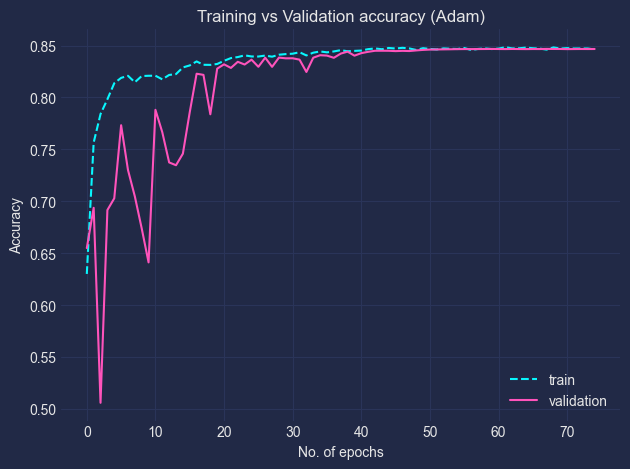

In [69]:
plt.plot(history_seg.history['accuracy'],'--')
plt.plot(history_seg.history['val_accuracy'])
plt.legend(['train', 'validation'], loc='lower right')
plt.title("Training vs Validation accuracy (Adam)")
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.savefig('Segnet_accuracy(adam).png')

In [77]:
x = history_seg.history['loss']
y = history_seg.history['val_loss']

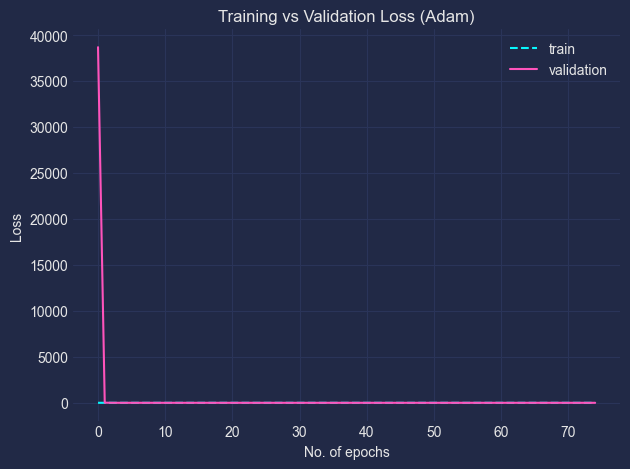

In [82]:
plt.plot(x,'--')
plt.plot(y)
plt.legend(['train', 'validation'], loc='upper right')
plt.title("Training vs Validation Loss (Adam)")
plt.xlabel("No. of epochs")
plt.ylabel("Loss")
plt.tight_layout()
plt.savefig('segnet_loss(adam).png')

In [83]:
# model_seg.save('saved_models/segnet.h5')

## PSPnet

In [86]:
def conv_block(X,filters,block):
    # resiudal block with dilated convolutions
    # add skip connection at last after doing convoluion operation to input X
    
    b = 'block_'+ str(block) + '_'
    f1,f2,f3 = filters
    X_skip = X
    # block_a
    X = Convolution2D(filters=f1,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'a')(X)
    X = BatchNormalization(name=b+'batch_norm_a')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_a')(X)
    # block_b
    X = Convolution2D(filters=f2,kernel_size=(3,3),dilation_rate=(2,2),
                      padding='same',kernel_initializer='he_normal',name=b+'b')(X)
    X = BatchNormalization(name=b+'batch_norm_b')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_b')(X)
    # block_c
    X = Convolution2D(filters=f3,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'c')(X)
    X = BatchNormalization(name=b+'batch_norm_c')(X)
    # skip_conv
    X_skip = Convolution2D(filters=f3,kernel_size=(3,3),padding='same',name=b+'skip_conv')(X_skip)
    X_skip = BatchNormalization(name=b+'batch_norm_skip_conv')(X_skip)
    # block_c + skip_conv
    X = Add(name=b+'add')([X,X_skip])
    X = ReLU(name=b+'relu')(X)
    return X
    
def base_feature_maps(input_layer):
    # base covolution module to get input image feature maps 
    
    # block_1
    base = conv_block(input_layer,[32,32,64],'1')
    # block_2
    base = conv_block(base,[64,64,128],'2')
    # block_3
    base = conv_block(base,[128,128,256],'3')
    return base

def pyramid_feature_maps(input_layer):
    # pyramid pooling module
    
    base = base_feature_maps(input_layer)
    # red
    red = GlobalAveragePooling2D(name='red_pool')(base)
    red = tf.keras.layers.Reshape((1,1,256))(red)
    red = Convolution2D(filters=64,kernel_size=(1,1),name='red_1_by_1')(red)
    red = UpSampling2D(size=256,interpolation='bilinear',name='red_upsampling')(red)
    # yellow
    yellow = AveragePooling2D(pool_size=(2,2),name='yellow_pool')(base)
    yellow = Convolution2D(filters=64,kernel_size=(1,1),name='yellow_1_by_1')(yellow)
    yellow = UpSampling2D(size=2,interpolation='bilinear',name='yellow_upsampling')(yellow)
    # blue
    blue = AveragePooling2D(pool_size=(4,4),name='blue_pool')(base)
    blue = Convolution2D(filters=64,kernel_size=(1,1),name='blue_1_by_1')(blue)
    blue = UpSampling2D(size=4,interpolation='bilinear',name='blue_upsampling')(blue)
    # green
    green = AveragePooling2D(pool_size=(8,8),name='green_pool')(base)
    green = Convolution2D(filters=64,kernel_size=(1,1),name='green_1_by_1')(green)
    green = UpSampling2D(size=8,interpolation='bilinear',name='green_upsampling')(green)
    # base + red + yellow + blue + green
    return tf.keras.layers.concatenate([base,red,yellow,blue,green])

def last_conv_module(input_layer):
    X = pyramid_feature_maps(input_layer)
    X = Convolution2D(filters=3,kernel_size=3,padding='same',name='last_conv_3_by_3')(X)
    X = BatchNormalization(name='last_conv_3_by_3_batch_norm')(X)
    # X = Activation('sigmoid',name='last_conv_relu')(X)
    X = Convolution2D(1, (1, 1), activation='sigmoid')(X)
    # X = tf.keras.layers.Flatten(name='last_conv_flatten')(X)
    # X = tf.keras.Dense()
    return X

In [87]:
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

In [88]:
inputs = Input(shape = input_shape)
s = Lambda(lambda x : x / 255)(inputs)

In [89]:
inputs.shape , s.shape

(TensorShape([None, 256, 256, 3]), TensorShape([None, 256, 256, 3]))

In [95]:
output_layer = last_conv_module(s)
model_psp = Model(inputs=s,outputs=output_layer)

In [96]:
model_psp.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block_1_a (Conv2D)             (None, 256, 256, 32  128         ['input_17[0][0]']               
                                )                                                                 
                                                                                                  
 block_1_batch_norm_a (BatchNor  (None, 256, 256, 32  128        ['block_1_a[1][0]']              
 malization)                    )                                                           

In [97]:
model_psp.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy',dice_coef,dice_loss,iou_coef,bce_dice_loss])

In [98]:
X_train.shape , Y_train.shape

((450, 256, 256, 3), (450, 256, 256, 1))

In [99]:
import gc
gc.collect()

202

In [100]:
history_psp = model.fit(X_train,Y_train,validation_data = (X_val,Y_val),epochs=100,batch_size=4,callbacks=callbacks)

Epoch 1/100
113/113 [==============================] - 90s 564ms/step - loss: 0.4263 - accuracy: 0.8311 - dice_coef: 0.6111 - dice_loss: 0.3889 - iou_coef: 0.4315 - bce_dice_loss: 0.6208 - val_loss: 0.3872 - val_accuracy: 0.8334 - val_dice_coef: 0.6822 - val_dice_loss: 0.3178 - val_iou_coef: 0.5085 - val_bce_dice_loss: 0.5461 - lr: 0.0010
Epoch 2/100
113/113 [==============================] - 51s 451ms/step - loss: 0.3639 - accuracy: 0.8551 - dice_coef: 0.6583 - dice_loss: 0.3417 - iou_coef: 0.4795 - bce_dice_loss: 0.5349 - val_loss: 0.4105 - val_accuracy: 0.8328 - val_dice_coef: 0.7045 - val_dice_loss: 0.2955 - val_iou_coef: 0.5359 - val_bce_dice_loss: 0.5582 - lr: 0.0010
Epoch 3/100
113/113 [==============================] - 51s 451ms/step - loss: 0.3446 - accuracy: 0.8578 - dice_coef: 0.6730 - dice_loss: 0.3270 - iou_coef: 0.4969 - bce_dice_loss: 0.5081 - val_loss: 0.3408 - val_accuracy: 0.8585 - val_dice_coef: 0.7302 - val_dice_loss: 0.2698 - val_iou_coef: 0.5653 - val_bce_dice_los

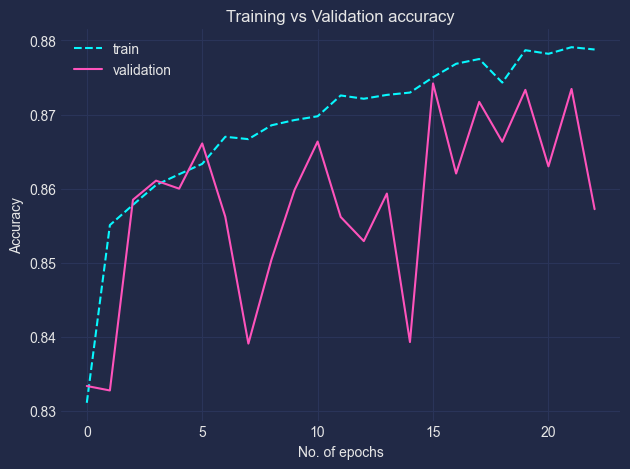

In [101]:
plt.plot(history_psp.history['accuracy'],'--')
plt.plot(history_psp.history['val_accuracy'])
plt.legend(['train', 'validation'], loc='upper left')
plt.title("Training vs Validation accuracy")
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.savefig('pspnet_accuracy.png')

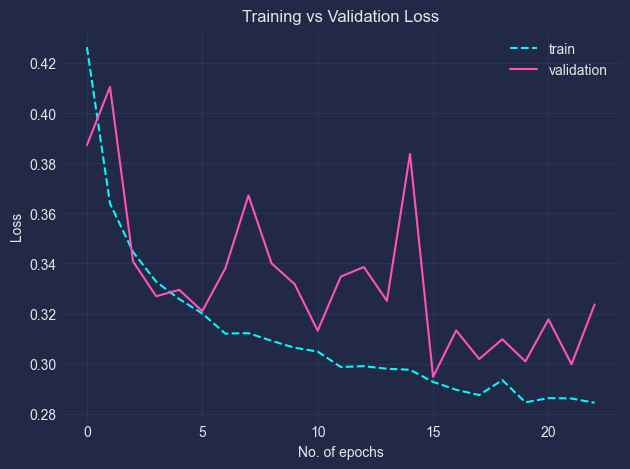

In [102]:
plt.plot(history_psp.history['loss'],'--')
plt.plot(history_psp.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper right')
plt.title("Training vs Validation Loss")
plt.xlabel("No. of epochs")
plt.ylabel("Loss")
plt.tight_layout()
plt.savefig('pspnet_loss.png')